# CEIA - Análisis de Datos
## Trabajo Práctico Número 2

### Grupo: 

          - Martín A. Brocca 
          - Agustín A. Lopez Fredes 

Dataset seleccionado: [AirBnB Dataset](https://insideairbnb.com/get-the-data/)

In [1]:
# importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import geopandas as gpd
from shapely.geometry import Point
import missingno as msno



#### De acuerdo a lo realizado en el TP1, el problema seleccionado cuenta con un dataset conformado por 7 archivos:
| **Archivo**                | **Descripción**                                                                 |
|------------------------|------------------------------------------------------------------------------|
| Listing.csv.gz         | Listado detallado de inmuebles                                               |
| Calendar.csv.gz        | Información detallada de fechas de reserva y ocupación                       |
| Reviews.csv.gz         | Listado detallado de opiniones y valoraciones de usuarios                    |
| Listing.csv            | Versión resumida del listado de inmuebles para facilitar visualizaciones     |
| Neighbourhoods.csv     | Listado de barrios de la localidad                                           |
| Neighbourhoods.geojson | Archivo GeoJson con los barrios de la localidad                              |


El dataset corresponde a los últimos 12 meses a cierre de Enero 2025

Se utilizarán los archivos detallados para el EDA, como así también el archivo geojson para la representación gráfica de algunas conclusiones o reportes.


In [2]:
#  URL para descargar todos los archivos que conforman el dataset
data_base_url = "https://data.insideairbnb.com/argentina/ciudad-aut%C3%B3noma-de-buenos-aires/buenos-aires/2025-01-29"


# Definimos los nombres de los archivos y sus correspondientes URLs
data_files = {
    "df_listings_details": "/data/listings.csv.gz",
    "df_reviews_details": "/data/reviews.csv.gz",
    "df_calendar": "/data/calendar.csv.gz",
    "df_listings": "/visualisations/listings.csv",
    "df_reviews": "/visualisations/reviews.csv",
    "df_neighbourhoods": "/visualisations/neighbourhoods.csv",
}


# Carga directa de los archivos CSV desde la URL
dfs = {
    #name: pd.read_csv(base_url + filename, compression="gzip" if filename.endswith(".gz") else None)
    name: pd.read_csv(data_base_url + filename)
    for name, filename in data_files.items()
}
# Carga del archivo GeoJSON
dfs["df_neighbourhoods_geojson"] = gpd.read_file(
    data_base_url + "/visualisations/neighbourhoods.geojson"
)


In [3]:
# Creación de las variables individuales.
df_listings_details = dfs["df_listings_details"]
#df_neighborhoods = dfs["df_neighbourhoods"]
#df_reviews_details = dfs["df_reviews_details"]
#df_calendar = dfs["df_calendar"]

In [4]:
# Convertimos el precio en float, limpiando los caracteres previamente
# Elimina símbolo de dólar, comas y espacios, luego convierte a float
df_listings_details['price'] = (
    df_listings_details['price']
    .replace('[\$,]', '', regex=True)  # quita $ y ,
    .astype(float)
)

Debido a que el dataset de listings cuenta con 45 columnas, en el TP1 determinamos aquellas de interés:

In [5]:
df_listings_details_interes = df_listings_details[['id','property_type', 'room_type', 
                                           'name', 'description','accommodates', 'bedrooms', 'beds', 
                                            'bathrooms','price', 'availability_eoy',
                                            'estimated_occupancy_l365d', 'review_scores_rating',
                                            'review_scores_accuracy', 'review_scores_cleanliness',  'review_scores_checkin', 
                                            'review_scores_communication','review_scores_location','latitude', 'longitude', 
                                            'review_scores_value','number_of_reviews','reviews_per_month', 
                                            'neighbourhood', 'neighbourhood_cleansed',
                                            'host_identity_verified', 'host_has_profile_pic']]

### 1. Objetivo del problema

Queremos predecir el nivel de ocupación que tendrá cada propiedad, por lo que el target será el nivel de disponibilidad anual de los listings ('availability_eoy'). Esta variable muestra la cantidad de días que una propiedad estuvo disponible en el año, por lo que es el complemento de la ocupación. 
Desde el punto de vista del negocio, predecir esta variable me permitiría saber la rentabilidad esperada de una propiedad, en función de las características de las mismas (habitaciones, camas, baños), de la estrategia de precio adoptada, etc.

Dado que es una variable numérica, estamos ante un problema de regresión, pero se debe tener en cuenta que la variable es numérica discreta y representa días en el año, yendo de 0 a 365, por lo que una predicción debe estar acotada entre estos valores

#### 2. Repaso de valores atípicos/faltantes

En el TP1 se analizaron los valores faltantes y outliers. Repasamos las cantidades para determinar si se eliminan las filas/columnas o se imputan:

In [6]:
# Función para informar las columnas con mayor cantidad de datos faltantes orderadas de mayor a menor
def report_missing(df):
    missing_report = (
        df.isnull().sum()
        .to_frame(name='missing_count')
        .assign(missing_pct=lambda x: (x['missing_count'] / len(df)) * 100)
        .sort_values(by='missing_count', ascending=False)
    )
    return missing_report

In [7]:
#función para graficar los datos faltantes
def plot_missing(df, name):
    plt.figure(figsize=(20, 6))
    sns.heatmap(df.isnull(), cbar=False)
    plt.title(f"Missing Data Heatmap - {name}")
    plt.show()

In [8]:
# Función auxiliar para detectar outliers
def detectar_outliers(df):
    # Seleccionar solo columnas numéricas
    columnas_numericas = df.select_dtypes(include=[np.number]).columns
    results = []

    for col in columnas_numericas:
        # Calcular IQR
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        # Límites para IQR con umbral 1.5
        limite_inferior_iqr_1_5 = Q1 - 1.5 * IQR
        limite_superior_iqr_1_5 = Q3 + 1.5 * IQR
        
        # Límites para IQR con umbral 3 (outliers severos)
        limite_inferior_iqr_3 = Q1 - 3 * IQR
        limite_superior_iqr_3 = Q3 + 3 * IQR

        # Calcular media y desviación estándar (umbral fijo de 3)
        mean = df[col].mean()
        std = df[col].std()
        limite_inferior_std = mean - 3 * std
        limite_superior_std = mean + 3 * std

        # Identificar outliers
        outliers_iqr_1_5 = df[(df[col] < limite_inferior_iqr_1_5) | (df[col] > limite_superior_iqr_1_5)]
        outliers_iqr_3 = df[(df[col] < limite_inferior_iqr_3) | (df[col] > limite_superior_iqr_3)]
        outliers_std = df[(df[col] < limite_inferior_std) | (df[col] > limite_superior_std)]

        # Calcular porcentajes
        total_data_points = len(df[col].dropna())
        outlier_percentage_iqr_1_5 = (len(outliers_iqr_1_5) / total_data_points) * 100 if total_data_points > 0 else 0
        outlier_percentage_iqr_3 = (len(outliers_iqr_3) / total_data_points) * 100 if total_data_points > 0 else 0
        outlier_percentage_std = (len(outliers_std) / total_data_points) * 100 if total_data_points > 0 else 0

        # Guardar resultados
        results.append({
            'Columna': col,
            'Porcentaje Outliers (Umbral 1.5 * IQR)': round(outlier_percentage_iqr_1_5, 2),
            'Porcentaje Outliers Severos (Umbral 3 * IQR)': round(outlier_percentage_iqr_3, 2),
            'Porcentaje Outliers (Umbral 3 * STD)': round(outlier_percentage_std, 2)
        })

    # Convertir resultados a DataFrame
    result_df = pd.DataFrame(results)
    
    # Ordenar por porcentaje de outliers (Umbral 1.5 * IQR) de mayor a menor
    result_df_sorted = result_df.sort_values(by='Porcentaje Outliers Severos (Umbral 3 * IQR)', ascending=False)
    
    # Generar gráfico de barras con Seaborn
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=result_df_sorted,
        x='Columna',
        y='Porcentaje Outliers Severos (Umbral 3 * IQR)',
        color='#4e79a7'  # Azul oscuro compatible con temas claros y oscuros
    )
    plt.title('Porcentaje de Outliers por Columna (Umbral 3 * IQR)')
    plt.xlabel('Columnas')
    plt.ylabel('Porcentaje de Outliers (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return result_df

#### Valores faltantes
##### Listings

In [9]:
report_missing(df_listings_details_interes)

,missing_count,missing_pct
neighbourhood,18584,52.837484
review_scores_accuracy,5761,16.379506
review_scores_value,5761,16.379506
review_scores_checkin,5760,16.376663
reviews_per_month,5760,16.376663
review_scores_location,5760,16.376663
review_scores_rating,5760,16.376663
review_scores_communication,5760,16.376663
review_scores_cleanliness,5760,16.376663
price,3574,10.161492


Analizamos el solapamiento que hay entre valores faltantes para determinar la técnica de imputación o eliminación:

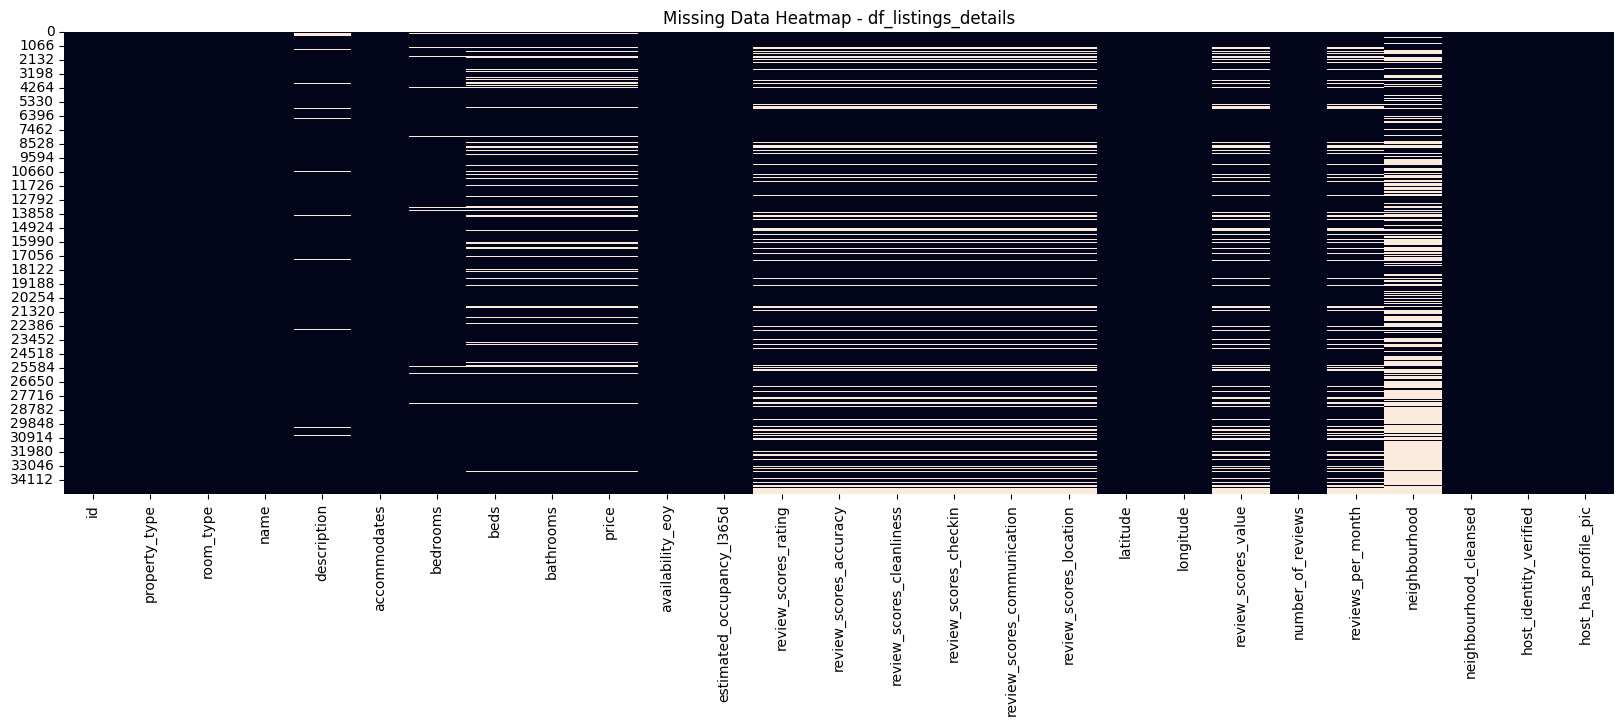

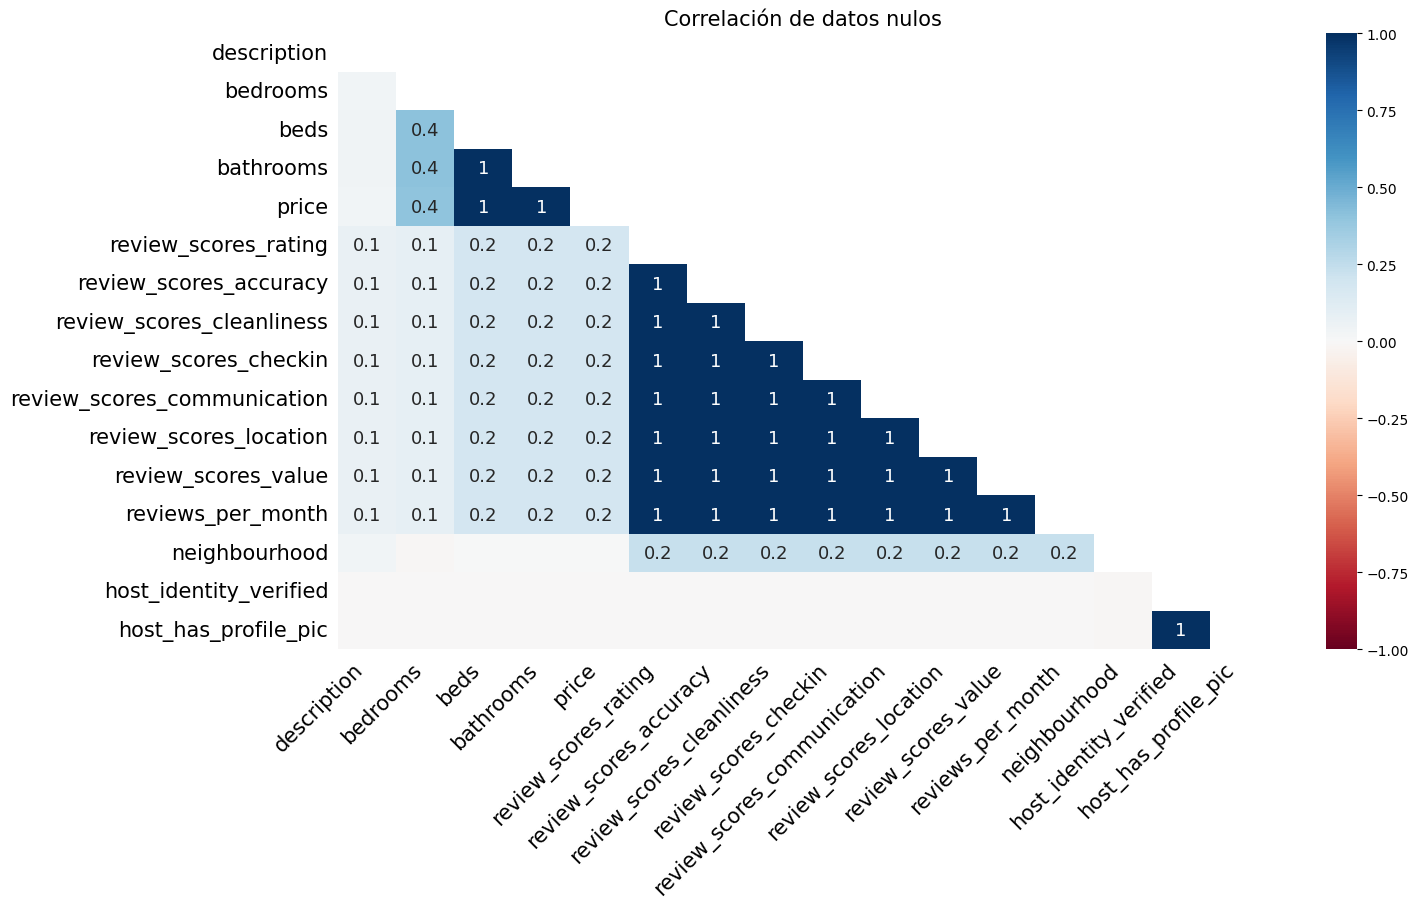

In [10]:
import missingno as msno
plot_missing(df_listings_details_interes, "df_listings_details")

msno.heatmap(df_listings_details_interes, fontsize=15, figsize=(15,8))
plt.title("Correlación de datos nulos", fontsize=15)
plt.show()

- Para 'neighbourhood', observamos que la podemos reemplazar variable 'neighbourhood_cleansed' que no tiene faltantes, por lo que la eliminamos. 
- 'description' es una variable de texto que no se utilizará para el modelado, por lo que se elimina también
- 'host_has_profile_pic' y 'host_identity_verified' sólo tienen 6 valores faltantes, por lo que podemos eliminar las filas
- Los faltantes de precio coinciden con faltantes de baños y camas al 100%, pero con el número de habitaciones al 40%. Dado que estas variables representan un 10% y coinciden, eliminamos las filas con NA de precio, baños y camas, pero imputaremos el de número de habitaciones, que tiene menor coincidencia en sus faltantes con el resto, y tendremos valores para hacer la imputación.
- Para el resto haremos imputaciones (previo split train/test) 

In [11]:
print(f"Shape original de dataset:{df_listings_details_interes.shape}")
print(f"Valores faltantes en dataset antes de imputación: {df_listings_details_interes.isnull().sum()}")


df_listings_details_interes.drop(columns=['id','neighbourhood', 'description'], inplace=True)
df_listings_details_interes.dropna(subset=['host_has_profile_pic', 'host_identity_verified', 'price', 'beds', 'bathrooms'], inplace=True)
print(f"Shape resultante:{df_listings_details_interes.shape}")
print(f"Valores faltantes en X_test antes de imputación: {df_listings_details_interes.isnull().sum()}")

Shape original de dataset:(35172, 27)
Valores faltantes en dataset antes de imputación: id                                 0
property_type                      0
room_type                          0
name                               0
description                      873
accommodates                       0
bedrooms                         727
beds                            3568
bathrooms                       3570
price                           3574
availability_eoy                   0
estimated_occupancy_l365d          0
review_scores_rating            5760
review_scores_accuracy          5761
review_scores_cleanliness       5760
review_scores_checkin           5760
review_scores_communication     5760
review_scores_location          5760
latitude                           0
longitude                          0
review_scores_value             5761
number_of_reviews                  0
reviews_per_month               5760
neighbourhood                  18584
neighbourhood_cleansed  

C:\Users\alope\AppData\Local\Temp\ipykernel_27356\594444329.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_details_interes.drop(columns=['id','neighbourhood', 'description'], inplace=True)
C:\Users\alope\AppData\Local\Temp\ipykernel_27356\594444329.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_details_interes.dropna(subset=['host_has_profile_pic', 'host_identity_verified', 'price', 'beds', 'bathrooms'], inplace=True)


Observamos que luego de eliminar los nulos de camas, baños y precio, apenas quedan 38 valores nulos de habitaciones

#### Outliers
##### Listings

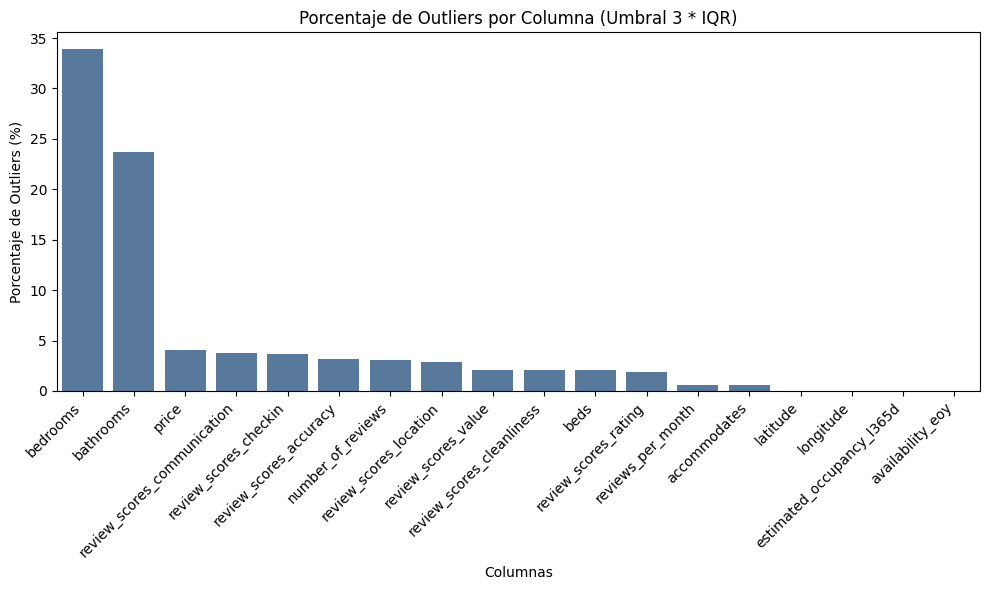

,Columna,Porcentaje Outliers (Umbral 1.5 * IQR),Porcentaje Outliers Severos (Umbral 3 * IQR),Porcentaje Outliers (Umbral 3 * STD)
0,accommodates,1.62,0.55,1.62
1,bedrooms,33.87,33.87,1.59
2,beds,9.74,2.05,1.20
3,bathrooms,23.72,23.72,1.47
4,price,8.53,4.09,0.11
5,availability_eoy,0.00,0.00,0.00
6,estimated_occupancy_l365d,5.63,0.00,0.00
7,review_scores_rating,5.43,1.84,1.60
8,review_scores_accuracy,6.06,3.21,1.53
9,review_scores_cleanliness,5.93,2.07,1.66


In [12]:
porcentaje_outliers_listings = detectar_outliers(df_listings_details_interes)
porcentaje_outliers_listings

Se observa que en general el porcentaje de valores atípicos es bajo, aunque hay variables como bathrooms, bedrooms que contienen un porcentaje elevado según el criterio de IQR, no así por el criterio de la desviación estándar

#### 3. Split train/test

Haremos un split de train/test guardando 20% de los datos para test. Por el momento la variable target se encuentra dentro del dataset, pero será separada posteriormente

In [13]:
from sklearn.model_selection import train_test_split

print(f"Shape original de listings: {df_listings_details_interes.shape}")
X_train, X_test = train_test_split(df_listings_details_interes, test_size=0.2)

print(f"Shape de train: {X_train.shape}")
print(f"Shape de test: {X_test.shape}")

Shape original de listings: (31572, 24)
Shape de train: (25257, 24)
Shape de test: (6315, 24)


### 4. Imputación de valores atípicos y faltantes

#### Imputar valores faltantes

Para analizar la imputación, primero analizamos la correlación:

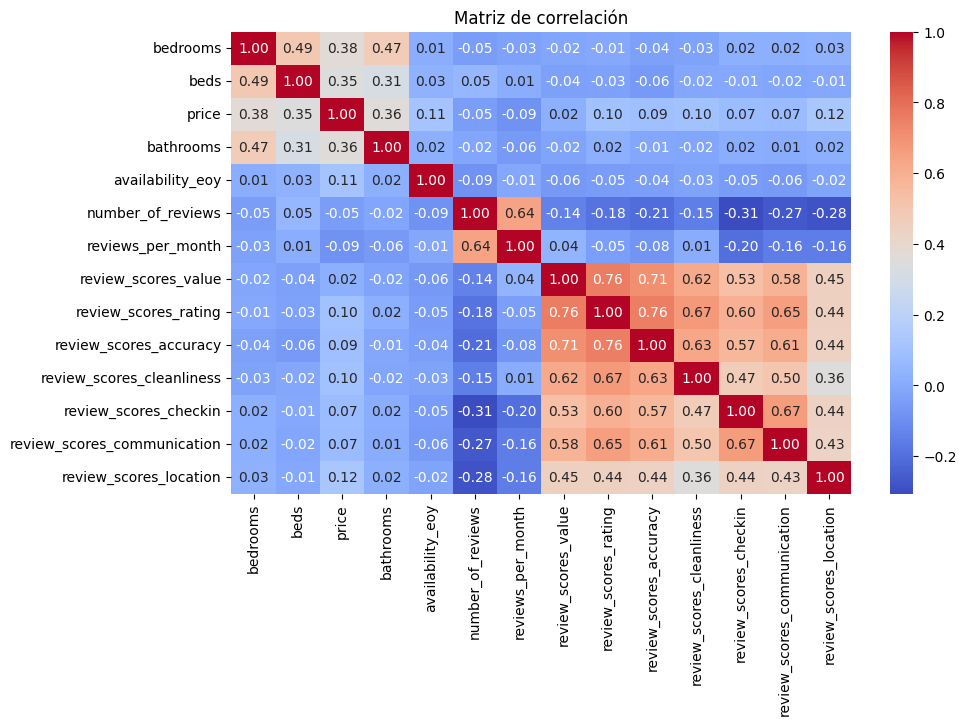

In [14]:
columnas_corr = ['bedrooms', 'beds', 'price', 'bathrooms', 'availability_eoy', 'number_of_reviews', 'reviews_per_month', 
                 'review_scores_value','review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                 'review_scores_checkin', 'review_scores_communication', 'review_scores_location']

plt.figure(figsize=(10, 6))
sns.heatmap(X_train[columnas_corr].corr(method='spearman'), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación')
plt.show()

- La variable bedrooms tiene correlación con beds, bathrooms, y un poco menor con price, que ya no tenían nulos, por lo que podemos utilizar una regresión para imputarla
- Las variables de reviews tienen alta correlación entre sí, pero como vimos sus faltantes coincidían al 100%, por lo que no es posible usarlas para imputar. Las alternivas son:
    - Eliminar las filas, pero representan aprox 16% del dataset
    - Eliminar las columnas, perdiendo toda la información de reviews
    - Imputar con la moda, pero esto cambiaría drásticamente la distribución
    - Imputar con el resto de las variables, lo que implica usar variables con correlación baja
    - Codificarla con un valor que indique la ausencia, por ejemplo -1, pero los modelos podrían confundir este menor como un valor más bajo de review

Finalmente, lo que haremos será imputar con MICE, pero generar una columna adicional que indique la ausencia de review

In [15]:
columnas_con_faltantes = ['bedrooms',
                          'review_scores_rating', 'review_scores_accuracy',
                          'review_scores_cleanliness', 'review_scores_checkin',
                          'review_scores_communication','review_scores_location',
                          'reviews_per_month', 'review_scores_value']

Comenzamos aplicando una regresión lineal para imputar los bedrooms faltantes

In [16]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression




# Guardar copias de los DataFrames originales
X_train_original = X_train.copy()
X_test_original = X_test.copy()

print("Valores faltantes en X_train antes de imputación:")
print(X_train_original.isnull().sum())
print("\nValores faltantes en X_test antes de imputación:")
print(X_test_original.isnull().sum())

# --- Imputación de 'bedrooms' con regresión lineal ---
# Seleccionar predictores para la regresión lineal (beds, bathrooms, price)
predictores = ['beds', 'bathrooms', 'price']

# Crear máscaras para filas con y sin valores faltantes en bedrooms
mask_train_no_null = ~X_train['bedrooms'].isna()
mask_test_no_null = ~X_test['bedrooms'].isna()
mask_train_null = X_train['bedrooms'].isna()
mask_test_null = X_test['bedrooms'].isna()

# Entrenar el modelo de regresión lineal con las filas sin nulos en X_train
lr = LinearRegression()
lr.fit(X_train[mask_train_no_null][predictores], X_train[mask_train_no_null]['bedrooms'])

# Predecir valores para las filas con nulos
X_train.loc[mask_train_null, 'bedrooms'] = lr.predict(X_train[mask_train_null][predictores])
X_test.loc[mask_test_null, 'bedrooms'] = lr.predict(X_test[mask_test_null][predictores])

# Redondear y asegurar que los valores sean enteros no negativos
X_train['bedrooms'] = X_train['bedrooms'].round().clip(lower=0).astype(int)
X_test['bedrooms'] = X_test['bedrooms'].round().clip(lower=0).astype(int)

print("Valores faltantes en X_train antes de imputación:")
print(X_train.isnull().sum())
print("\nValores faltantes en X_test antes de imputación:")
print(X_test.isnull().sum())


Valores faltantes en X_train antes de imputación:
property_type                     0
room_type                         0
name                              0
accommodates                      0
bedrooms                         33
beds                              0
bathrooms                         0
price                             0
availability_eoy                  0
estimated_occupancy_l365d         0
review_scores_rating           3594
review_scores_accuracy         3595
review_scores_cleanliness      3594
review_scores_checkin          3594
review_scores_communication    3594
review_scores_location         3594
latitude                          0
longitude                         0
review_scores_value            3594
number_of_reviews                 0
reviews_per_month              3594
neighbourhood_cleansed            0
host_identity_verified            0
host_has_profile_pic              0
dtype: int64

Valores faltantes en X_test antes de imputación:
property_type          

In [17]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

review_columns = [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'reviews_per_month'
]

# --- Crear columna que indique cuando no tuvo reseñas ---
X_train['Sin_reviews'] = X_train['review_scores_rating'].isna().astype(int)
X_test['Sin_reviews'] = X_test['review_scores_rating'].isna().astype(int)

# --- Imputación de columnas de reseñas con MICE ---
# Seleccionar todas las columnas numéricas para MICE
columnas_numericas = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("\nColumnas numéricas usadas para MICE:", columnas_numericas)

# Crear el imputador MICE
imputer = IterativeImputer(max_iter=10, random_state=42)

# Seleccionar columnas numéricas para imputación
X_train_numeric = X_train[columnas_numericas]
X_test_numeric = X_test[columnas_numericas]

# Ajustar y transformar X_train
X_train_imputed = imputer.fit_transform(X_train_numeric)
# Transformar X_test con el mismo imputador
X_test_imputed = imputer.transform(X_test_numeric)

# Convertir los resultados a DataFrames
X_train_imputed = pd.DataFrame(X_train_imputed, columns=columnas_numericas, index=X_train.index)
X_test_imputed = pd.DataFrame(X_test_imputed, columns=columnas_numericas, index=X_test.index)

# Redondear y restringir las columnas de reseñas al rango 1-5
for col in review_columns:
    if col in X_train_imputed.columns:
        X_train_imputed[col] = X_train_imputed[col].round().clip(1, 5).astype(int)
        X_test_imputed[col] = X_test_imputed[col].round().clip(1, 5).astype(int)

# Asegurar que reviews_per_month sea no negativo
if 'reviews_per_month' in X_train_imputed.columns:
    X_train_imputed['reviews_per_month'] = X_train_imputed['reviews_per_month'].clip(lower=0)
    X_test_imputed['reviews_per_month'] = X_test_imputed['reviews_per_month'].clip(lower=0)

# Reemplazar las columnas imputadas en los DataFrames originales
# Solo reemplazar las columnas de reseñas, ya que bedrooms ya fue imputado
columnas_reviews = [col for col in columnas_con_faltantes if col != 'bedrooms']
X_train[columnas_reviews] = X_train_imputed[columnas_reviews]
X_test[columnas_reviews] = X_test_imputed[columnas_reviews]




Columnas numéricas usadas para MICE: ['accommodates', 'beds', 'bathrooms', 'price', 'availability_eoy', 'estimated_occupancy_l365d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'latitude', 'longitude', 'review_scores_value', 'number_of_reviews', 'reviews_per_month']


In [18]:
# Verificar que no hay valores faltantes después de la imputación
print("\nValores faltantes en X_train después de imputación:")
print(X_train.isnull().sum())
print("\nValores faltantes en X_test después de imputación:")
print(X_test.isnull().sum())


Valores faltantes en X_train después de imputación:
property_type                  0
room_type                      0
name                           0
accommodates                   0
bedrooms                       0
beds                           0
bathrooms                      0
price                          0
availability_eoy               0
estimated_occupancy_l365d      0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
latitude                       0
longitude                      0
review_scores_value            0
number_of_reviews              0
reviews_per_month              0
neighbourhood_cleansed         0
host_identity_verified         0
host_has_profile_pic           0
Sin_reviews                    0
dtype: int64

Valores faltantes en X_test después de imputación:
property_type                  0
room_type               

#### Imputar outliers

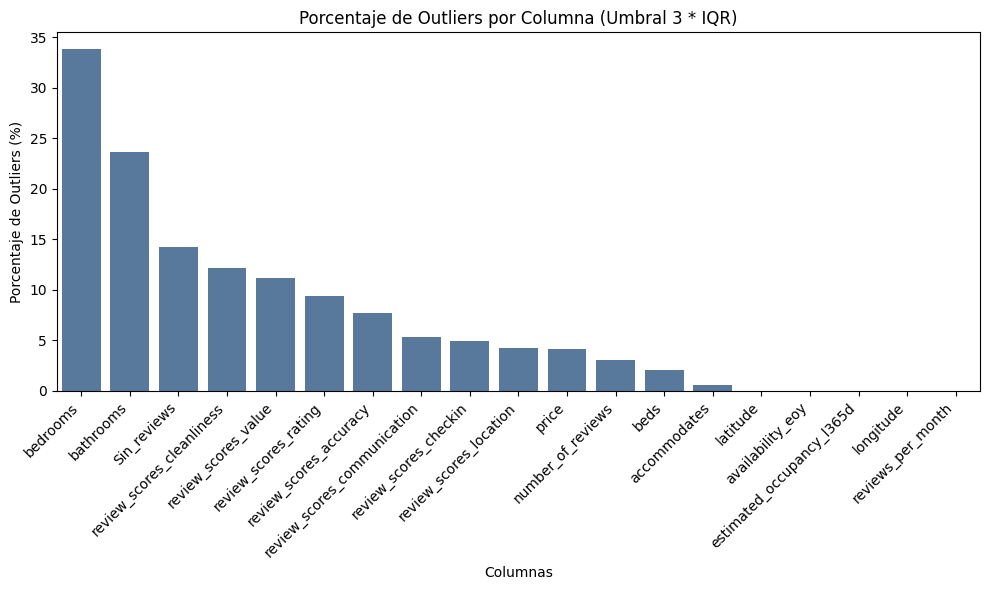


Columnas con outliers severos (IQR*3) a imputar: ['beds', 'bathrooms', 'bedrooms', 'price']

Columnas numéricas usadas para KNN: ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'price', 'availability_eoy', 'estimated_occupancy_l365d', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'latitude', 'longitude', 'review_scores_value', 'number_of_reviews', 'reviews_per_month', 'Sin_reviews']

Valores NaN en X_train después de imputación (outliers): 0
Valores NaN en X_test después de imputación (outliers): 0


In [19]:
from sklearn.impute import KNNImputer
# Detectar outliers en X_train
resultados_outliers = detectar_outliers(X_train)

# Filtrar columnas con outliers severos para imputar
outliers_severos = ['beds', 'bathrooms', 'bedrooms', 'price']
print("\nColumnas con outliers severos (IQR*3) a imputar:", outliers_severos)

# Guardar copias de los DataFrames originales para comparar
X_train_imputed_original = X_train.copy()
X_test_imputed_original = X_test.copy()

# Crear máscaras para identificar outliers (IQR*3) en X_train y X_test
mascaras_train = {}
mascaras_test = {}
for col in outliers_severos:
    Q1 = X_train[col].quantile(0.25)
    Q3 = X_train[col].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 3 * IQR
    limite_superior = Q3 + 3 * IQR
    
    # Máscaras para identificar outliers
    mascaras_train[col] = (X_train[col] < limite_inferior) | (X_train[col] > limite_superior)
    mascaras_test[col] = (X_test[col] < limite_inferior) | (X_test[col] > limite_superior)

# Copiar DataFrames para no modificar los originales
X_train_knn = X_train.copy()
X_test_knn = X_test.copy()

# Convertir outliers a NaN para imputarlos
for col in outliers_severos:
    X_train_knn.loc[mascaras_train[col], col] = np.nan
    X_test_knn.loc[mascaras_test[col], col] = np.nan

# Seleccionar todas las columnas numéricas para KNNImputer
columnas_numericas = X_train_knn.select_dtypes(include=['int32', 'int64', 'float64']).columns.tolist()
print("\nColumnas numéricas usadas para KNN:", columnas_numericas)

# Imputar con KNN usando todas las columnas numéricas
imputer_knn = KNNImputer(n_neighbors=5, weights='uniform')
X_train_knn_array = imputer_knn.fit_transform(X_train_knn[columnas_numericas])
X_test_knn_array = imputer_knn.transform(X_test_knn[columnas_numericas])

# Convertir los resultados a DataFrames
X_train_knn_imputed = pd.DataFrame(X_train_knn_array, columns=columnas_numericas, index=X_train_knn.index)
X_test_knn_imputed = pd.DataFrame(X_test_knn_array, columns=columnas_numericas, index=X_test_knn.index)

# Redondear y restringir columnas discretas
for col in ['beds', 'bedrooms']:
    if col in X_train_knn_imputed.columns:
        X_train_knn_imputed[col] = X_train_knn_imputed[col].round().clip(lower=0).astype(int)
        X_test_knn_imputed[col] = X_test_knn_imputed[col].round().clip(lower=0).astype(int)

# Restringir bathrooms a valores razonables (múltiplos de 0.5 como figura en el dataset original)
if 'bathrooms' in X_train_knn_imputed.columns:
    X_train_knn_imputed['bathrooms'] = (X_train_knn_imputed['bathrooms'] * 2).round() / 2
    X_test_knn_imputed['bathrooms'] = (X_test_knn_imputed['bathrooms'] * 2).round() / 2
    X_train_knn_imputed['bathrooms'] = X_train_knn_imputed['bathrooms'].clip(lower=0)
    X_test_knn_imputed['bathrooms'] = X_test_knn_imputed['bathrooms'].clip(lower=0)

# Asegurar que price sea no negativo
if 'price' in X_train_knn_imputed.columns:
    X_train_knn_imputed['price'] = X_train_knn_imputed['price'].clip(lower=0)
    X_test_knn_imputed['price'] = X_test_knn_imputed['price'].clip(lower=0)

# Reemplazar solo las columnas con outliers en los DataFrames originales
X_train[outliers_severos] = X_train_knn_imputed[outliers_severos]
X_test[outliers_severos] = X_test_knn_imputed[outliers_severos]

# Verificar que no queden NaN después de la imputación
print("\nValores NaN en X_train después de imputación (outliers):", X_train[outliers_severos].isna().sum().sum())
print("Valores NaN en X_test después de imputación (outliers):", X_test[outliers_severos].isna().sum().sum())


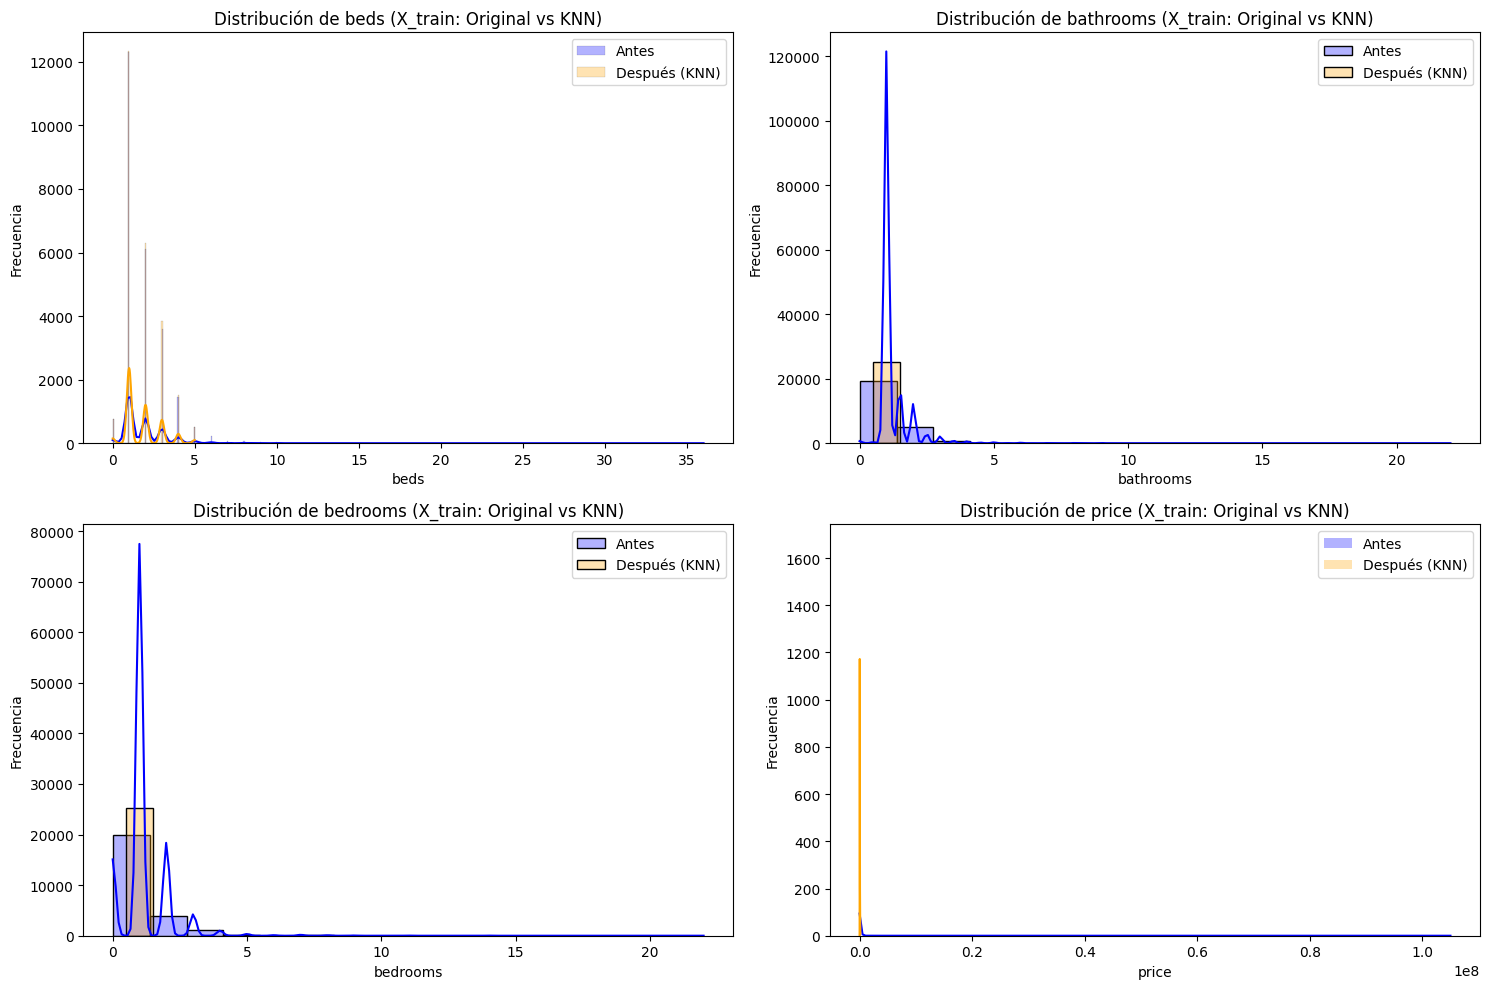

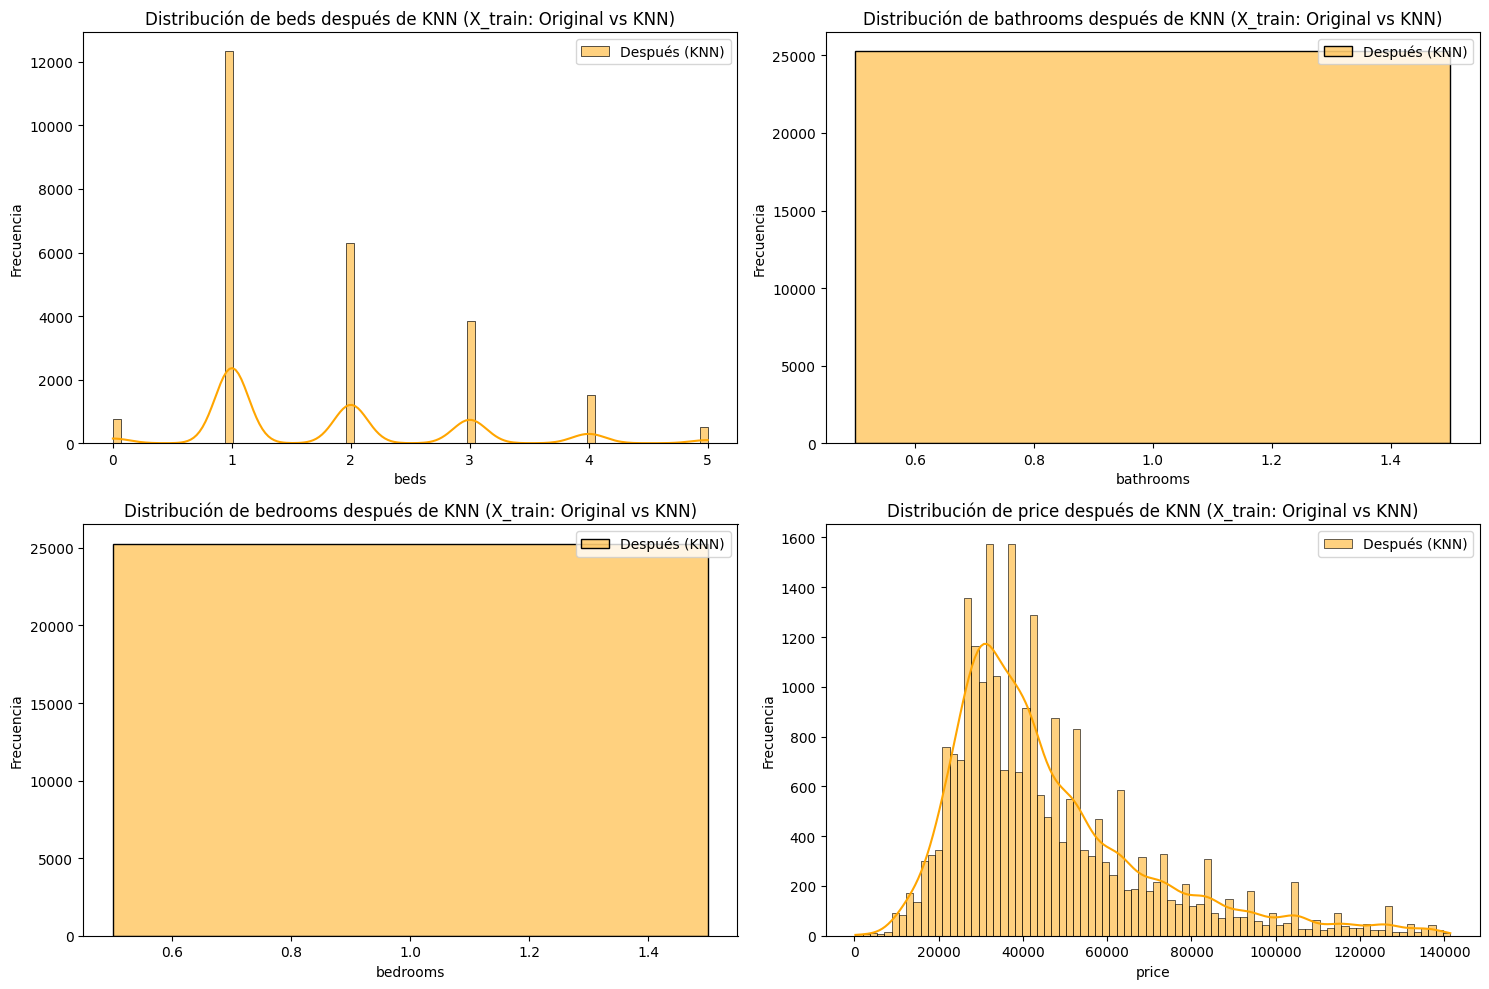

In [20]:

# Función para graficar distribuciones antes y después de la imputación
def plot_distributions(df_before, df_after, columns, title_suffix):
    n_cols = 2
    n_rows = (len(columns) + n_cols - 1) // n_cols

    # Primera figura: Comparación antes y después de KNN
    plt.figure(figsize=(15, 5 * n_rows))
    for i, col in enumerate(columns):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.histplot(df_before[col], kde=True, color='blue', alpha=0.3, label='Antes')
        sns.histplot(df_after[col], kde=True, color='orange', alpha=0.3, label='Después (KNN)')
        plt.title(f'Distribución de {col} {title_suffix}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.legend()
    plt.savefig("../images/distribucion_de_columnas.png", transparent=True, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

    # Segunda figura: Solo después (KNN)
    plt.figure(figsize=(15, 5 * n_rows))
    for i, col in enumerate(columns):
        plt.subplot(n_rows, n_cols, i + 1)
        sns.histplot(df_after[col], kde=True, color='orange', alpha=0.5, label='Después (KNN)')
        plt.title(f'Distribución de {col} después de KNN {title_suffix}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.legend()
    plt.tight_layout()
    plt.savefig("../images/distribucion_de_columnas_post_knn.png", transparent=True, bbox_inches='tight')
    plt.show()

# Graficar distribuciones para columnas con outliers imputados
plot_distributions(X_train_imputed_original, X_train, outliers_severos, '(X_train: Original vs KNN)')

Debido a que las distribuciones previas se ven distorsionadas por los outliers, no es posible comprar adecuadamente. Graficamos distribuciones limitando la variable para hacer la comparativa:

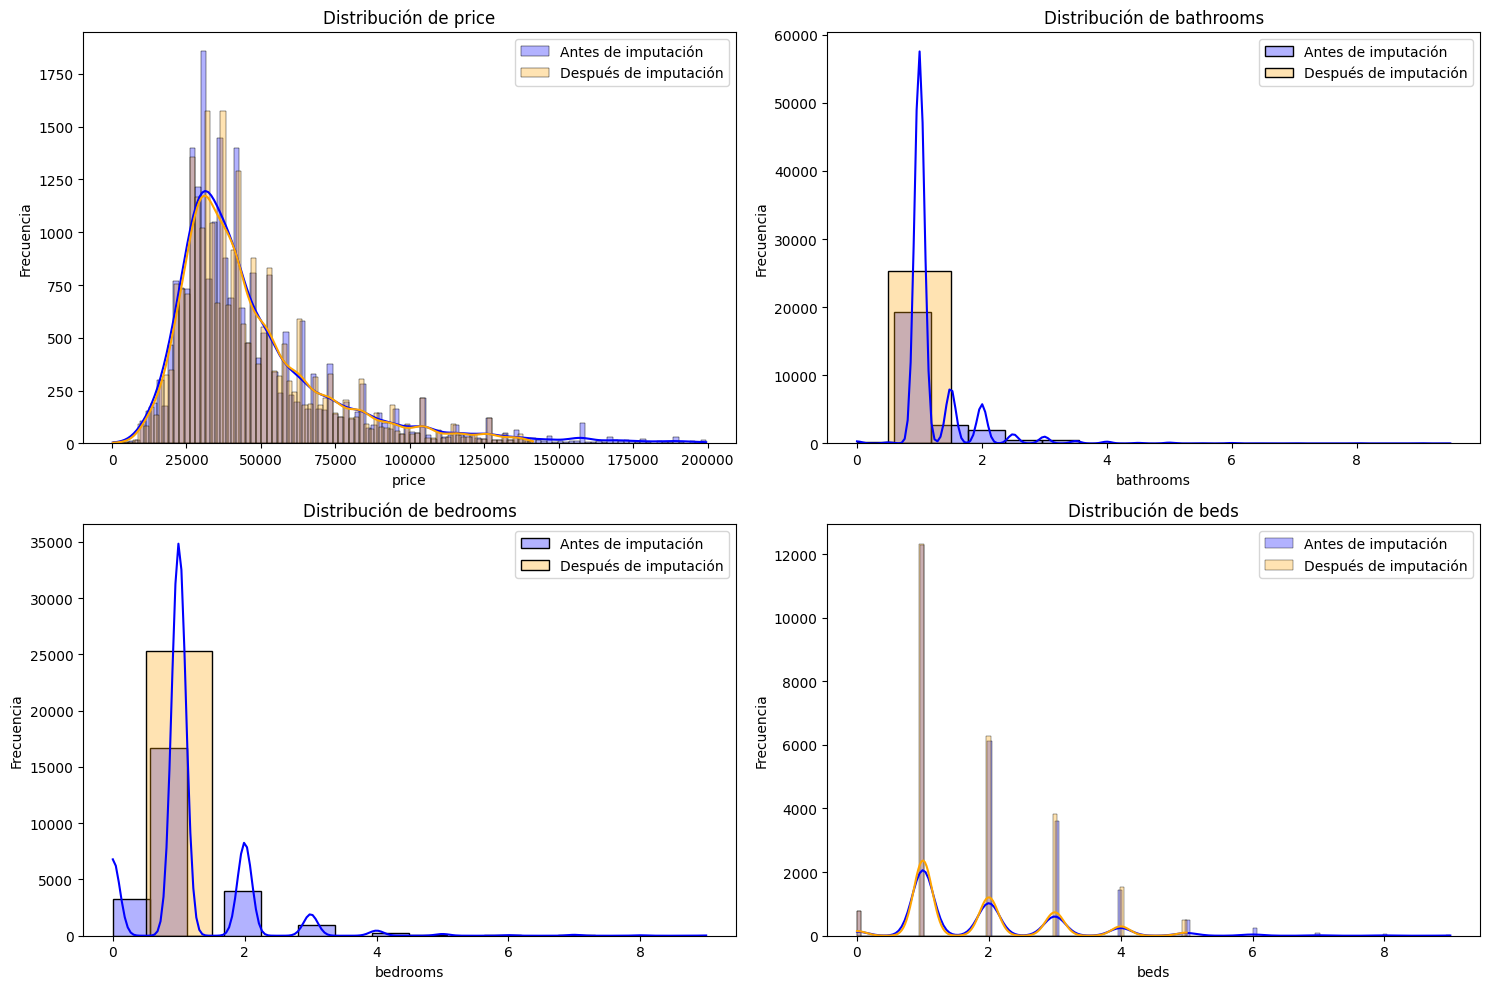

In [21]:
# Definir columnas a graficar
columnas = ['price', 'bathrooms', 'bedrooms', 'beds']

# Crear subplot 2x2
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Aplanar los ejes para facilitar el acceso en el bucle
axes = axes.flatten()

# Límites para filtrar valores extremos
limites = {
    'price': 200000,
    'bathrooms': 10,
    'bedrooms': 10,
    'beds': 10
}

# Graficar histogramas para cada columna en el subplot correspondiente
for i, col in enumerate(columnas):
    # Filtrar valores extremos para el DataFrame original
    mask = X_train_imputed_original[col] < limites[col]
    # Graficar distribución antes de imputación
    sns.histplot(X_train_imputed_original[mask][col], kde=True, color='blue', alpha=0.3, 
                 label='Antes de imputación', ax=axes[i])
    # Graficar distribución después de imputación
    sns.histplot(X_train[col], kde=True, color='orange', alpha=0.3, 
                 label='Después de imputación', ax=axes[i])
    # Configurar título, etiquetas y leyenda
    axes[i].set_title(f'Distribución de {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frecuencia')
    axes[i].legend()

# Ajustar el diseño para evitar solapamiento
plt.tight_layout()
plt.savefig("../images/distribuciones_columnas.png", transparent=True, bbox_inches='tight')

# Mostrar la figura completa
plt.show()

- Observamos que para price y beds, si bien elimina los outliers, la distribución se mantiene
- Para bedrooms y bathrooms no, la imputación está modificando la distribución, llevando las variables prácticamente a un valor único. Desestimamos entonces la imputación y retomamos el valor original

In [22]:
X_train['bedrooms'] = X_train_imputed_original['bedrooms']
X_test['bedrooms'] = X_test_imputed_original['bedrooms']
X_train['bathrooms'] = X_train_imputed_original['bathrooms']
X_test['bathrooms'] = X_test_imputed_original['bathrooms']

### 5. Análisis de desbalance

Si bien en ese caso la variable target 'availability_eoy' es una variable numérica, para analizar el desbalance se hace una conversión temporal a categórica. Para esto generamos tres categorías:
- Disponibilidad alta
- Disponibilidad media
- Disponibilidad baja

Estos pasos los realizamos únicamente para el dataset de entrenamiento, ya que el desbalance afecta al entrenamiento de los modelos y su capacidad para distinguir entre clases.
En el conjunto de test el desbalance no se corrige el desbalance, ya que es el conjunto sobre el que se evalúa, y debe preservarse el original. No obstante, en un problema de clasificación, convendría hacer un split train/test estratificado, para que el conjunto de test represente la distribución real.

In [23]:
min_availability = X_train['availability_eoy'].min()
max_availability = X_train['availability_eoy'].max()
rango = max_availability - min_availability

ancho_bin = (rango / 3).round()

# Generar los puntos de corte para 3 bins
bins = [min_availability + i * ancho_bin for i in range(4)]

# Ajustar el último bin para incluir max_availability (evitar errores de redondeo)
bins[-1] = max_availability

# Categorias
categorias = ['Baja', 'Media', 'Alta']

# Computar valores
X_train['availability_categoria'] = pd.cut(
    X_train['availability_eoy'],
    bins=bins,
    labels=categorias,
    include_lowest=True
)


X_train[['availability_eoy', 'availability_categoria']].head(20)

,availability_eoy,availability_categoria
19586,269,Alta
18231,0,Baja
13402,276,Alta
16852,309,Alta
1879,166,Media
11385,14,Baja
11100,12,Baja
34634,249,Alta
3825,234,Alta
27898,49,Baja


Analizamos el desbalance para el conjunto de entrenamiento:

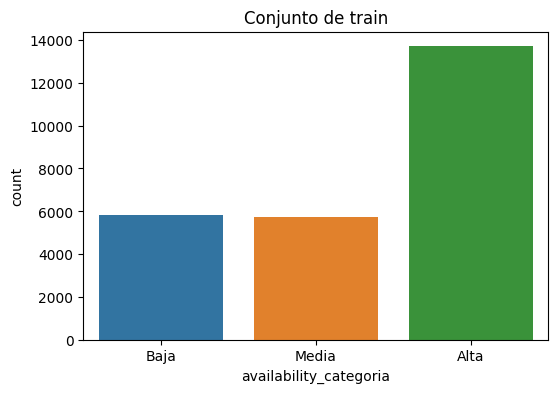

In [24]:
fig = plt.figure(figsize=(6,4))

sns.countplot(x=X_train['availability_categoria'], hue=X_train['availability_categoria'])
plt.title('Conjunto de train')
plt.savefig("../images/conjunto_de_train.png", transparent=True, bbox_inches='tight')

plt.show()


Se observa un desbalance importante en la categoría de disponibilidad Alta, teniendo más del doble de datos que el resto. Las formas de mitigar esto son las siguientes:
- SMOTE: generar datos sintéticos para la clase minoritaria interpolando entre datos usando KNN. Esto lleva a que las clases queden igualadas hacia arriba, y en este caso las clases Baja y Media tendrán la misma cantidad de datos que la Alta. Pero esto también implica que más de la mitad de los datos de Baja y Media serán datos sintéticos y no reales, lo que puede perjudicar el entrenamiento.
- Random Undersampler: muestrear de forma aleatoria menos datos de la clase mayoritaria. Esto iguala las clases hacia abajo, reduciendo en este caso la cantidad de datos de la clase Alta. Si bien ahora no tendríamos datos sintéticos, sí estamos eliminando datos 
- Una tercer alternativa, para algunos modelos, es utilizar pesos para darle mayor prioridad a la clase minoritaria, sin eliminar datos ni generar sintéticos. En este trabajo sólo se aborda el preprocesamiento y no el modelado en sí, por lo que no se explora esta alternativa

In [25]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

#Generamos copias del dataset original separando X e y
X_train_balanceo = X_train.copy()
y_train_balanceo = X_train_balanceo['availability_categoria']
X_train_balanceo = X_train_balanceo.drop(columns=['availability_categoria'])

# Separar columnas numéricas 
columnas_numericas = X_train_balanceo.select_dtypes(include=['int32', 'int64', 'float64']).columns.tolist()

# Oversampling con SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_balanceo[columnas_numericas], y_train_balanceo)


# Undersampling
undersample = RandomUnderSampler(random_state=42)
X_train_us, y_train_us = undersample.fit_resample(X_train_balanceo[columnas_numericas], y_train_balanceo)




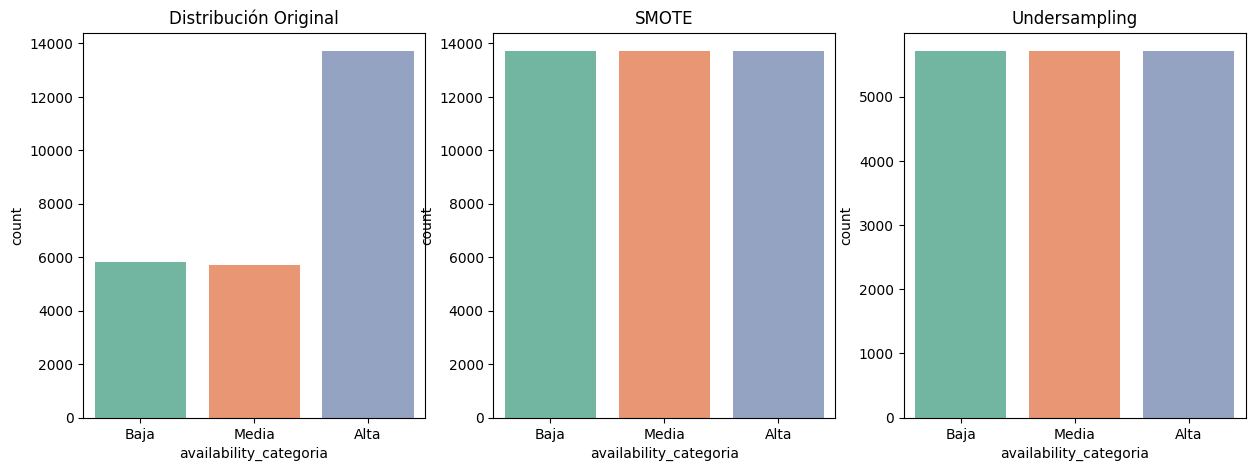

In [26]:
# Graficar las distribuciones original y balanceadas 
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.countplot(x=y_train_balanceo, hue=y_train_balanceo, palette="Set2", ax=axes[0])
sns.countplot(x=y_train_sm, hue=y_train_sm, palette="Set2", ax=axes[1])
sns.countplot(x=y_train_us, hue=y_train_us, palette="Set2", ax=axes[2])

axes[0].set_title('Distribución Original')
axes[1].set_title('SMOTE')
axes[2].set_title('Undersampling')

plt.savefig("../images/ditribuciones_original_vs_balanceadas.png", transparent=True, bbox_inches='tight')

plt.show()

- Como era esperado, SMOTE genera datos sintéticos, y ahora todas las clases equiparan en cantidad a la mayoritaria, lo que implica que pasaron prácticamente de 6000 datos a 14000, siendo entonces la mayoría sintéticos. Esto puede llegar a perjudicar el entrenamiento del modelo.
- El Undersampling elimina filas de la clase 'Alta', y en menor medida de 'Baja'. Esto implica que se eliminaron datos, lo que lleva a pérdida de información.

En última instancia, la elección de si utilizar balanceo depende del modelo a utilizar, por lo que lo conveniente es realizar la prueba con las tres alternativas y evaluar los resultados en las métricas para elegir el método a utilizar. En el caso de los modelos que pueden ajustar su peso para ponderar la clase minoritaria, es una alternativa más a tener en cuenta.

Un punto importante es que, comprobado el desbalance, para evaluar el modelo no es conveniente utilizar únicamente la métrica de Accuracy, ya que es sensible a que el modelo acierte prediciendo generalmente la clase mayoritaria. Se debe complementar esta métrica con otras como Precision, Recall, F1-Score o Área Bajo la Curva ROC.

In [27]:
# Eliminamos la columna generada
X_train.drop(columns=['availability_categoria'], inplace=True)

### 6. Análisis y selección de features

#### Generación de features nuevos
En primer lugar generamos los features nuevos, para luego decidir si permanecen en el dataset de acuerdo a los test estadísticos y análisis de correlación. Estos nuevos test se basan en el EDA realizado durante el TP1, donde se observó que una variable potencialmente relevante podía ser obtener los precios pounitarios por habitación, cama y baño:

In [28]:
X_train['precio_habitacion'] = X_train['price'] / X_train['bedrooms']
X_train['precio_cama'] = X_train['price'] / X_train['beds']
X_train['precio_baño'] = X_train['price'] / X_train['bathrooms']


X_test['precio_habitacion'] = X_test['price'] / X_test['bedrooms']
X_test['precio_cama'] = X_test['price'] / X_test['beds']
X_test['precio_baño'] = X_test['price'] / X_test['bathrooms']

variables_generadas = ['precio_habitacion', 'precio_cama', 'precio_baño']

# Reemplazar inf con el máximo/mínimo finito de la columna
for col in variables_generadas:
    finite_max = X_train[col][~np.isinf(X_train[col])].max()
    finite_min = X_train[col][~np.isinf(X_train[col])].min()
    X_train[col] = X_train[col].replace(np.inf, finite_max)
    
    # Aplicar lo mismo a X_test
    X_test[col] = X_test[col].replace(np.inf, finite_max)

#### Análisis de correlación
Repasamos los valores de correlación entre variables numéricas usando Spearman (al tener valores numéricos discretos)

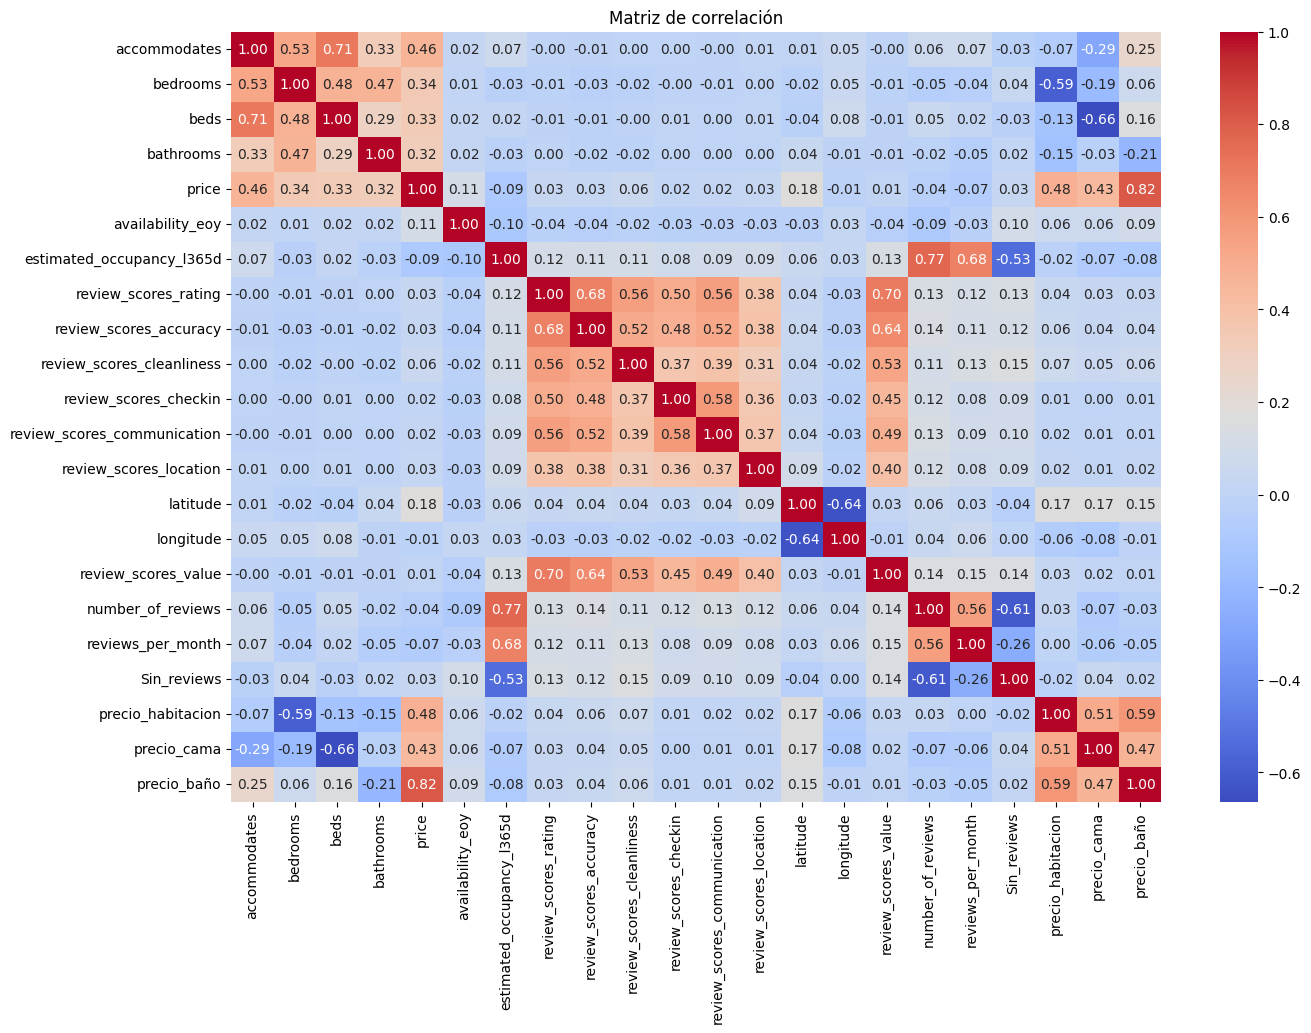

In [29]:
# Separar columnas numéricas 
columnas_numericas = X_train.select_dtypes(include=['int32', 'int64', 'float64']).columns.tolist()

plt.figure(figsize=(15, 10))
sns.heatmap(X_train[columnas_numericas].corr(method='spearman'), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación')
plt.savefig("../images/tp2_corr_matrix.png", transparent=True, bbox_inches='tight')

plt.show()

- **beds, bathrooms, bedrooms y price**: Estas variables muestran correlaciones moderadas positivas entre sí (0.31 a 0.49) y con price (0.35 a 0.37), indicando que el tamaño de la propiedad influye en el precio, aunque no de manera dominante. Esto sugiere que otros factores (como reseñas o ubicación) también son relevantes. Las nuevas variables generadas tienen alta correlación con el precio
- **Variables de reseñas**: Están altamente correlacionadas entre sí (0.43 a 1.00), con review_scores_rating como un reflejo general de las otras categorías. Sin embargo, su relación con price y las variables de tamaño es débil, excepto por review_scores_value (0.45 con price). La correlación perfecta entre algunas parejas de reseñas podría indicar un problema de datos que requiere limpieza o análisis adicional.
- **estimmated_ocuppancy**: tiene correlación fuerte con number of reviews y reviews por mes, y negativa con sin reviews. No obstante, tiene poca correlación con la ocupación real (su complemento sería 'availability_eoy')

#### Test estadísticos

Al ser un problema de regresión, no es posible usar Chi-cuadrado que se utiliza para categóricas, pero utilizamos ANOVA e información mutua que permiten tratar problemas de regresión

In [30]:
print(f"El dataset tiene {X_train_numeric.shape[1]} columnas numéricas")
# Definimos la cantidad de variables a mantener
cantidad_variables_mantener = 12

El dataset tiene 17 columnas numéricas


##### Anova

In [31]:
# Copiamos dataset originales
X_train_original = X_train.copy()
X_test_original = X_test.copy()

# Separamos target y columnas numericas
y_train = X_train['availability_eoy']
X_train = X_train.drop(columns='availability_eoy')

columnas_numericas = X_train.select_dtypes(include=['int32', 'int64', 'float64']).columns.tolist()
X_train_num = X_train[columnas_numericas]

y_test = X_test['availability_eoy']
X_test = X_test.drop(columns='availability_eoy')
X_test_num = X_test[columnas_numericas]

In [32]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression


# ANOVA (numéricas, fit en train, transformar ambos)
selector_anova = SelectKBest(score_func=f_regression, k=cantidad_variables_mantener) # Seleccionamos los 12 mejores features
X_train_num_best = selector_anova.fit_transform(X_train_num, y_train)
selected_indices = selector_anova.get_support()
selected_features = X_train_num.columns[selected_indices]
scores = selector_anova.scores_[selected_indices]
feature_score_dict_anova = {feature: score for feature, score in zip(selected_features, scores)}
print(f"Numéricas antes de filtrar: {X_train_num.columns}")
print("\nCaracterísticas seleccionadas (ANOVA):")
for feature, score in sorted(feature_score_dict_anova.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {score:.4f}")


Numéricas antes de filtrar: Index(['accommodates', 'bedrooms', 'beds', 'bathrooms', 'price',
       'estimated_occupancy_l365d', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'latitude', 'longitude',
       'review_scores_value', 'number_of_reviews', 'reviews_per_month',
       'Sin_reviews', 'precio_habitacion', 'precio_cama', 'precio_baño'],
      dtype='object')

Características seleccionadas (ANOVA):
price: 264.3085
precio_baño: 175.8435
Sin_reviews: 149.0851
estimated_occupancy_l365d: 76.5307
accommodates: 58.6013
precio_cama: 49.0351
precio_habitacion: 48.3179
review_scores_accuracy: 43.6552
review_scores_value: 39.6658
review_scores_rating: 36.0489
bedrooms: 31.2234
bathrooms: 27.4600


Se observa que el precio presenta la mayor relación, seguida por la variable generada que indicaba la ausencia de reviews, la variable generada de precio por baño, la ocupación estimada, cuanta gente acomoda, y el valor de reviews para el valor y exactitud del listing

##### Información mutua

In [33]:
from sklearn.feature_selection import mutual_info_regression

# Definir una versión de mutual_info_regression con random_state fijo
def mutual_info_regression_fixed_seed(X, y):
    return mutual_info_regression(X, y, random_state=42)

selector_mi = SelectKBest(score_func=mutual_info_regression_fixed_seed, k=cantidad_variables_mantener) # Problema de regression
X_train_mi_best = selector_mi.fit_transform(X_train_num, y_train) 
selected_indices = selector_mi.get_support()
selected_features = X_train_num.columns[selected_indices]
scores = selector_mi.scores_[selected_indices]
feature_score_dict_mi = {feature: score for feature, score in zip(selected_features, scores)}
print("\nCaracterísticas seleccionadas (Inf. mutua):")
for feature, score in sorted(feature_score_dict_mi.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {score:.4f}")


X_test_best = selector_mi.transform(X_train_num)





Características seleccionadas (Inf. mutua):
estimated_occupancy_l365d: 0.0713
precio_baño: 0.0609
latitude: 0.0599
price: 0.0581
longitude: 0.0569
number_of_reviews: 0.0534
precio_cama: 0.0484
precio_habitacion: 0.0390
reviews_per_month: 0.0375
Sin_reviews: 0.0311
beds: 0.0139
accommodates: 0.0096


Se observa que por alguna razón las variables de latitud y longitud tuvieron un score alto no reflejado en ANOVA. Dado que una de las variables categóricas es el barrio, que tienen relación con el target de acuerdo a lo visto en el TP1, no mantenemos estas variables de latitud y longitud.

Luego las variables de ocupación estimada y precio aparecen en los primeros lugares, al igual que en ANOVA; seguida de número de reviews, precio por cama, reviews por mes. 

Obtenemos la intersección de los resultados:

In [34]:
features_comunes = set(feature_score_dict_anova.keys()) & set(feature_score_dict_mi.keys())
intersection_dict = {
    feature: {'ANOVA_Score': feature_score_dict_anova[feature], 'MI_Score': feature_score_dict_mi[feature]}
    for feature in features_comunes
}

features_comunes

{'Sin_reviews',
 'accommodates',
 'estimated_occupancy_l365d',
 'precio_baño',
 'precio_cama',
 'precio_habitacion',
 'price'}

Finalmente, seleccionamos las 7 variables de la intersección, ya que surgieron como relevantes en ambos análisis, y sumamos:
- **review_scores_value, review_scores_accuracy y bedrooms**, que salieron seleccionadas en el análisis de ANOVA. Como vimos las variables de scores de reviews están fuertemente correlacionadas, así que tomando las dos mencionadas podríamos capturar buena parte de la información  que aportan
- **number_of_reviews**, que salió seleccionada en el criterio de información mutua. Nuevamente, como hay correlación entre number_of_reviews y reviews_per_month, que también salió seleccionada, podemos tomar la primera y descartar la segunda

In [35]:
columnas_numericas_mantener = [feature for feature in features_comunes]
columnas_numericas_mantener.extend(['bedrooms', 'number_of_reviews'])
#columnas_numericas_mantener.extend(['review_scores_value', 'review_scores_accuracy', 'bedrooms', 'number_of_reviews'])
columnas_numericas_mantener

['precio_habitacion',
 'accommodates',
 'Sin_reviews',
 'estimated_occupancy_l365d',
 'price',
 'precio_baño',
 'precio_cama',
 'bedrooms',
 'number_of_reviews']

Para las columnas categóricas:
- Mantenemos **neighbourhood_cleansed**, que como se analizó en el TP1 es una variable relevante para la variable target
- Convertimos **property_type** de acuerdo a lo realizado en el TP1, simplificando las propiedades en 4 tipos
- El resto de las variables categóricas no guardan relación con la variable target de acuerdo a lo analizado en el EDA, por lo que procedemos a descartarlas

In [36]:
def clasificar_alojamiento(row):
    tipo = row['property_type'].lower()
    if 'entire rental unit' in tipo:
        return 'entire_rental_unit'
    elif 'entire condo' in tipo:
        return 'entire_condo'
    elif 'shared room' in tipo:
        return 'habitacion_compartida'
    elif 'private room' in tipo:
        return 'habitacion_privada'
    elif 'entire' in tipo:
        return 'propiedad_completa_otros'
    else:
        return 'otros'

X_train['property_type_summary'] = X_train.apply(clasificar_alojamiento, axis =1)
X_test['property_type_summary'] = X_test.apply(clasificar_alojamiento, axis =1)

In [37]:
columnas_categoricas_mantener = ['neighbourhood_cleansed', 'property_type_summary']

columnas_mantener = columnas_numericas_mantener + columnas_categoricas_mantener

# Removemos Sin_reviews de las columnas numericas, ya que en realidad es categorica binaria
columnas_numericas_mantener.remove('Sin_reviews')

columnas_mantener

['precio_habitacion',
 'accommodates',
 'Sin_reviews',
 'estimated_occupancy_l365d',
 'price',
 'precio_baño',
 'precio_cama',
 'bedrooms',
 'number_of_reviews',
 'neighbourhood_cleansed',
 'property_type_summary']

Aplicamos la selección de features a los dataset de train y test

In [38]:
X_train_limpio = X_train[columnas_mantener].copy()
X_test_limpio = X_train[columnas_mantener].copy()
X_train_limpio.head()

,precio_habitacion,accommodates,Sin_reviews,estimated_occupancy_l365d,price,precio_baño,precio_cama,bedrooms,number_of_reviews,neighbourhood_cleansed,property_type_summary
19586,37356.000000,2,0,30,37356.0,24904.000000,37356.0,1,11,Villa Crespo,entire_rental_unit
18231,28051.000000,2,0,90,28051.0,28051.000000,28051.0,1,41,Palermo,entire_rental_unit
13402,18904.000000,3,0,48,18904.0,18904.000000,4726.0,1,26,Barracas,habitacion_privada
16852,16852.333333,6,0,255,50557.0,33704.666667,10111.4,3,84,San Nicolas,entire_rental_unit
1879,140729.000000,2,0,40,32557.0,32557.000000,32557.0,0,147,Colegiales,entire_rental_unit


In [39]:
#list columns in X_train_limpio
print(f"Columnas en X_train_limpio: {X_train_limpio.columns.tolist()}")
# print total number of columns
print(f"Total de columnas en X_train_limpio: {X_train_limpio.shape[1]}")

Columnas en X_train_limpio: ['precio_habitacion', 'accommodates', 'Sin_reviews', 'estimated_occupancy_l365d', 'price', 'precio_baño', 'precio_cama', 'bedrooms', 'number_of_reviews', 'neighbourhood_cleansed', 'property_type_summary']
Total de columnas en X_train_limpio: 11


### 6. Transformación de variables: estandarización y codificación

Para las variables numéricas, aplicamos una estandarización. Utilizamos StandardScaler en lugar de MinMax, ya que modelos como SVM, regresión logística, redes neuronales o k-means asumen que los datos están centrados y escalados:

Para variables categóricas, tenemos que:
- **Sin_reviews** ya es una variable binaria, por lo que no requiere codificación
- **property_type_summary** tiene baja cardinalidad, por lo que podemos aplicar One-Hot encoding
- **neighbourhood_cleansed** tiene alta cardinalidad (48 valores distintos), por lo que no es conveniente usar One-Hot encoding. Dado que LabelEncoder puede perjudicar a algunos modelos al asumir que el número implica un orden, optamos por utilizar HashingEncoder

In [40]:
print(f"Cantidad de valores distintos de neighbourhood_cleansed: {X_train_limpio['neighbourhood_cleansed'].nunique()}")

Cantidad de valores distintos de neighbourhood_cleansed: 48


In [41]:
columnas_numericas_mantener

['precio_habitacion',
 'accommodates',
 'estimated_occupancy_l365d',
 'price',
 'precio_baño',
 'precio_cama',
 'bedrooms',
 'number_of_reviews']

In [42]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import HashingEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

n_componentes_hashing = 10

# Definir las columnas
columnas_numericas = list(dict.fromkeys(columnas_numericas_mantener))  # Lista de columnas numéricas
one_hot_columns = ['property_type_summary']    # Baja cardinalidad
hashing_columns = ['neighbourhood_cleansed']   # Alta cardinalidad

# Crear los transformadores
numeric_transformer = StandardScaler()
one_hot_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
hashing_transformer = HashingEncoder(cols=hashing_columns, n_components=n_componentes_hashing)

# Crear el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, columnas_numericas_mantener),
        ('one_hot', one_hot_transformer, one_hot_columns),
        ('hashing', hashing_transformer, hashing_columns)
    ],
    remainder='passthrough'  # Conservar la columna de Sin_reviews
)

# Ajustar y transformar el conjunto de entrenamiento
X_train_encoded = preprocessor.fit_transform(X_train_limpio)

# Transformar el conjunto de prueba
X_test_encoded = preprocessor.transform(X_test_limpio)

# Obtener los nombres de las columnas después de la transformación
one_hot_feature_names = preprocessor.named_transformers_['one_hot'].get_feature_names_out(one_hot_columns).tolist()
hashing_feature_names = [f'neighbourhood_cleansed_hash_{i}' for i in range(preprocessor.named_transformers_['hashing'].n_components)]
passthrough_columns = [col for col in X_train_limpio.columns if col not in columnas_numericas + one_hot_columns + hashing_columns]
all_feature_names = columnas_numericas + one_hot_feature_names + hashing_feature_names + passthrough_columns



In [43]:
# Convertir los resultados a DataFrames
X_train_encoded = pd.DataFrame(X_train_encoded, columns=all_feature_names, index=X_train_limpio.index)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=all_feature_names, index=X_test_limpio.index)

# Verificar el resultado
print("Columnas generadas:", X_train_encoded.columns.tolist())
X_train_encoded.head()

Columnas generadas: ['precio_habitacion', 'accommodates', 'estimated_occupancy_l365d', 'price', 'precio_baño', 'precio_cama', 'bedrooms', 'number_of_reviews', 'property_type_summary_entire_condo', 'property_type_summary_entire_rental_unit', 'property_type_summary_habitacion_compartida', 'property_type_summary_habitacion_privada', 'property_type_summary_otros', 'property_type_summary_propiedad_completa_otros', 'neighbourhood_cleansed_hash_0', 'neighbourhood_cleansed_hash_1', 'neighbourhood_cleansed_hash_2', 'neighbourhood_cleansed_hash_3', 'neighbourhood_cleansed_hash_4', 'neighbourhood_cleansed_hash_5', 'neighbourhood_cleansed_hash_6', 'neighbourhood_cleansed_hash_7', 'neighbourhood_cleansed_hash_8', 'neighbourhood_cleansed_hash_9', 'Sin_reviews']


,precio_habitacion,accommodates,estimated_occupancy_l365d,price,precio_baño,precio_cama,bedrooms,number_of_reviews,property_type_summary_entire_condo,property_type_summary_entire_rental_unit,...,neighbourhood_cleansed_hash_1,neighbourhood_cleansed_hash_2,neighbourhood_cleansed_hash_3,neighbourhood_cleansed_hash_4,neighbourhood_cleansed_hash_5,neighbourhood_cleansed_hash_6,neighbourhood_cleansed_hash_7,neighbourhood_cleansed_hash_8,neighbourhood_cleansed_hash_9,Sin_reviews
19586,-0.359238,-0.615768,-0.461148,-0.358793,-0.696852,0.150511,-0.190320,-0.401886,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18231,-0.598566,-0.615768,0.320570,-0.751200,-0.552352,-0.203525,-0.190320,0.243173,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
13402,-0.833829,0.021340,-0.226633,-1.136943,-0.972354,-1.090995,-0.190320,-0.079357,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16852,-0.886599,1.932665,2.470293,0.197914,-0.292753,-0.886091,2.036645,1.167759,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1879,2.299546,-0.615768,-0.330862,-0.561174,-0.345450,-0.032081,-1.303802,2.522384,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 7. Reducción de dimensionalidad

##### PCA (Principal Component Analysis)

In [44]:
# A continuación, procedemos a aplicar PCA sobre los datasets ya transformados y escalados.
from sklearn.decomposition import PCA

In [45]:
# Copiamos el dataset de train y test para no modificar los originales
X_train_pca = X_train_encoded.copy()
X_test_pca = X_test_encoded.copy()

In [46]:
pca = PCA(n_components=0.95, random_state=42)  # Mantener el 95% de la varianza
X_train_pca = pca.fit_transform(X_train_pca)
X_test_pca = pca.transform(X_test_pca)
# Convertir los resultados a DataFrames
X_train_pca = pd.DataFrame(X_train_pca, index=X_train_encoded.index)
X_test_pca = pd.DataFrame(X_test_pca, index=X_test_encoded.index)
# Verificar el resultado de aplicar PCA
print("Dimensiones originales:")
print(f"Train: {X_train_encoded.shape}, Test: {X_test_encoded.shape}")
print("Dimensiones después de PCA:")
print(f"Train: {X_train_pca.shape}, Test: {X_test_pca.shape}")
# Guardar los DataFrames finales

Dimensiones originales:
Train: (25257, 25), Test: (25257, 25)
Dimensiones después de PCA:
Train: (25257, 13), Test: (25257, 13)


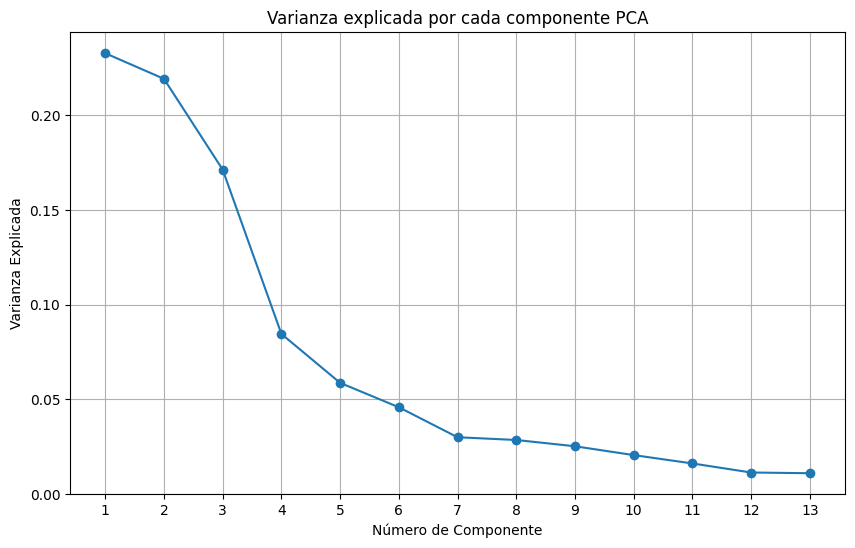

In [47]:
# realizamos el plot de la varianza explicada por cada componente
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o')
plt.title('Varianza explicada por cada componente PCA')
plt.xlabel('Número de Componente')
plt.ylabel('Varianza Explicada')
plt.xticks(range(1, len(pca.explained_variance_ratio_) + 1))
plt.grid()
plt.savefig("../images/varianza_explicada_pca.png", transparent=True, bbox_inches='tight')
plt.show()

In [48]:
pca.explained_variance_ratio_

array([0.2327152 , 0.21918889, 0.17124878, 0.08450764, 0.05868245,
       0.04580479, 0.02997504, 0.02852021, 0.02520291, 0.02054337,
       0.01613095, 0.01135096, 0.01097226])

Tras aplicar PCA, se redujo la dimensionalidad del conjunto de datos de 28 a 9 variables, conservando aproximadamente el 95% de la varianza total. Las primeras tres componentes explican más del 62% de la varianza, lo que indica que gran parte de la información original está concentrada en pocas dimensiones.


##### LDA (Linear Discriminant Analysis) No aplica al ser un problema de regresión, por lo que no se aplica.

##### UMAP (Uniform Manifold Approximation and Projection)

In [49]:
import umap.umap_ as umap

umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, random_state=42)
X_train_umap = umap_model.fit_transform(X_train_encoded)
X_test_umap = umap_model.transform(X_test_encoded)
# Convertir los resultados a DataFrames
X_train_umap = pd.DataFrame(X_train_umap, index=X_train_encoded.index, columns=['UMAP1', 'UMAP2'])
X_test_umap = pd.DataFrame(X_test_umap, index=X_test_encoded.index, columns=['UMAP1', 'UMAP2'])
# Verificar el resultado de aplicar UMAP
print("Dimensiones originales:")
print(f"Train: {X_train_encoded.shape}, Test: {X_test_encoded.shape}")
print("Dimensiones después de UMAP:")
print(f"Train: {X_train_umap.shape}, Test: {X_test_umap.shape}")

c:\Users\alope\AppData\Local\pypoetry\Cache\virtualenvs\ceia-analisis-de-datos-OtUdTlHF-py3.11\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Dimensiones originales:
Train: (25257, 25), Test: (25257, 25)
Dimensiones después de UMAP:
Train: (25257, 2), Test: (25257, 2)


In [50]:
from sklearn.metrics import silhouette_score

sil_score = silhouette_score(X_train_umap, y_train)
print(f"Silhouette Score: {sil_score:.4f}")

Silhouette Score: -0.2569


In [51]:
X_train_umap.shape, X_test_umap.shape, y_train.shape, y_test.shape

((25257, 2), (25257, 2), (25257,), (6315,))

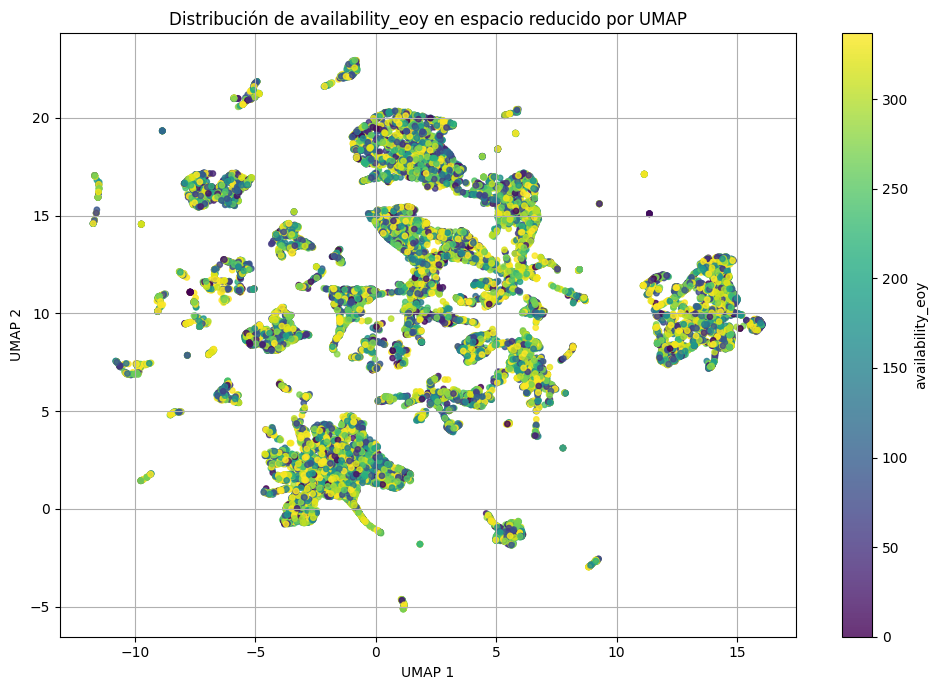

In [52]:
import matplotlib.pyplot as plt

# Asumiendo que:
# X_train_umap es un array de shape (25257, 2) con las dos dimensiones UMAP
# y_train contiene las etiquetas de clase para cada punto

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    X_train_umap.iloc[:, 0],     # Columna 1
    X_train_umap.iloc[:, 1],     # Columna 2
    c=y_train,    # Variable objetivo continua
    cmap='viridis',
    s=15,
    alpha=0.8
)
plt.colorbar(scatter, label='availability_eoy')
plt.title('Distribución de availability_eoy en espacio reducido por UMAP')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.grid(True)
plt.savefig("../images/distribucion_umap.png", transparent=True, bbox_inches='tight')
plt.tight_layout()
plt.show()


Al aplicar UMAP para reducir la dimensionalidad del dataset de 25 variables originales a 2 dimensiones, se logró una representación mucho más compacta para entrenamiento y prueba (ambos con 25,257 muestras). Sin embargo, el puntaje de Silhouette negativo (-0.2539) indica que la separación entre las clases no es clara en este espacio reducido, sugiriendo que los grupos están bastante solapados o mal definidos tras la transformación.